<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/dev%2Fvidi/notebooks/vidi/nb_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/dev%2Fvidi/notebooks/vidi/nb_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project Setup and Data Loading

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Dict, List, Tuple, Optional
import scipy.ndimage

warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(31)
np.random.seed(31)

Using device: cuda


## Dataset Download and Setup

In [3]:
# @title Setup Kaggle secret key
!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [4]:
# @title Setup dataset in Colab
import zipfile
import os
from google.colab import drive

drive.mount('/content/drive')

# Paths
zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
drive_extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"
local_dataset_path = "/content/dataset"  # for current session

# ---------------------------
# Step 1: Download zip (if not exists in /content)
# ---------------------------
if not os.path.exists(zip_path):
    print("Dataset not found locally, downloading...")
    !kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining -p /content
else:
    print("Dataset already exists, skipping download.")

# ---------------------------
# Step 2: Extract to Google Drive (for backup)
# ---------------------------
os.makedirs(drive_extract_path, exist_ok=True)

if not os.listdir(drive_extract_path):  # Check if folder is empty
    print("Extracting dataset to Google Drive...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(drive_extract_path)
    print("Dataset extracted to:", drive_extract_path)
else:
    print("Dataset already extracted at:", drive_extract_path)

# ---------------------------
# Step 3: Copy dataset to local /content (faster training)
# ---------------------------
if not os.path.exists(local_dataset_path):
    print("Copying dataset to Colab local storage (/content)...")
    !cp -r "$drive_extract_path" "$local_dataset_path"
else:
    print("Dataset already available in Colab local storage.")

# ---------------------------
# Step 4: Define dataset paths for training
# ---------------------------
TRAIN_IMG_DIR = os.path.join(local_dataset_path, "train", "images")
TRAIN_LBL_DIR = os.path.join(local_dataset_path, "train", "labels")
TEST_IMG_DIR  = os.path.join(local_dataset_path, "test", "images")

print("Train images:", TRAIN_IMG_DIR)
print("Train labels:", TRAIN_LBL_DIR)
print("Test images:", TEST_IMG_DIR)

Mounted at /content/drive
Dataset not found locally, downloading...
 60% 125M/209M [00:00<00:00, 1.30GB/s]
100% 209M/209M [00:00<00:00, 849MB/s] 
Dataset already extracted at: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset
Copying dataset to Colab local storage (/content)...
Train images: /content/dataset/train/images
Train labels: /content/dataset/train/labels
Test images: /content/dataset/test/images


# 2. Data Preprocessing

### Data overview

In [5]:
def load_crowd_counts(
    label_dir: str
) -> Dict[str, int]:
    """Load crowd counts from JSON label files."""
    crowd_counts = {}
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.json')]

    for label_file in label_files:
        img_name = label_file.replace('.json', '.jpg')
        label_path = os.path.join(label_dir, label_file)

        with open(label_path, 'r') as f:
            data = json.load(f)
            crowd_counts[img_name] = data.get('human_num', 0)

    return crowd_counts

def create_density_map(
    annotations: List[Tuple[int, int]],
    img_height: int,
    img_width: int,
    sigma: float = 15.0
) -> np.ndarray:
    """
    Create density map from point annotations using Gaussian kernels.
    """
    density_map = np.zeros((img_height, img_width), dtype=np.float32)

    for x, y in annotations:
        if 0 <= x < img_width and 0 <= y < img_height:
            density_map[y, x] = 1.0

    # Apply Gaussian filter to create density map
    density_map = scipy.ndimage.gaussian_filter(density_map, sigma=sigma)

    return density_map

def load_annotations_and_density(
    label_dir: str,
    img_dir: str
) -> Dict[str, Tuple[int, np.ndarray]]:
    """Load annotations and create density maps for training."""
    data_dict = {}
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.json')]

    for label_file in label_files:
        img_name = label_file.replace('.json', '.jpg')
        label_path = os.path.join(label_dir, label_file)
        img_path = os.path.join(img_dir, img_name)

        if not os.path.exists(img_path):
            continue

        # Load image to get dimensions
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_height, img_width = img.shape[:2]

        with open(label_path, 'r') as f:
            data = json.load(f)
            count = data.get('human_num', 0)

            # Get point annotations (assuming they exist in the JSON)
            points = []
            if 'annotations' in data:
                for ann in data['annotations']:
                    if 'bbox' in ann:
                        # Convert bbox to center point
                        x, y, w, h = ann['bbox']
                        center_x = x + w // 2
                        center_y = y + h // 2
                        points.append((center_x, center_y))

            # Create density map
            density_map = create_density_map(points, img_height, img_width)

            # Resize density map to quarter resolution for training efficiency
            target_height = img_height // 4
            target_width = img_width // 4
            density_map = cv2.resize(density_map, (target_width, target_height))

            data_dict[img_name] = (count, density_map)

    return data_dict

# Load crowd counts and create density maps
crowd_counts = load_crowd_counts(TRAIN_LBL_DIR)
print(f"Loaded {len(crowd_counts)} crowd count labels")

Loaded 1900 crowd count labels


### Data Augmentation

In [6]:
# Data augmentation transforms
train_transforms = A.Compose(
  [
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.RandomResizedCrop(height=512, width=512, size=(512, 512), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.7),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
  ],
  additional_targets={'density': 'mask'},
  is_check_shapes=False
)

val_transforms = A.Compose(
  [
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
  ],
  additional_targets={'density': 'mask'},
  is_check_shapes=False
)

test_transforms = A.Compose(
  [
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
  ],
  is_check_shapes=False
)

# 3. Dataset Loading

In [8]:
class HybridCrowdDataset(Dataset):
    """Dataset for hybrid density + count regression training."""

    def __init__(
        self,
        image_dir: str,
        crowd_counts: dict,
        image_files: list,
        transform=None,
        use_density_maps: bool = True
    ):
        self.image_dir = image_dir
        self.crowd_counts = crowd_counts
        self.image_files = [f for f in image_files if f in crowd_counts]
        self.transform = transform
        self.use_density_maps = use_density_maps

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx: int):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image (BGR → RGB)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Count label
        count = self.crowd_counts[img_name]
        img_height, img_width = image.shape[:2]

        # Create simple density map (uniform distribution)
        target_height = img_height // 4
        target_width = img_width // 4
        density_map = np.full(
            (target_height, target_width),
            count / (target_height * target_width),
            dtype=np.float32
        )

        # Apply Albumentations transforms
        if self.transform:
            augmented = self.transform(image=image)
            augmented_image = augmented["image"]  # Tensor [C, H, W]
        else:
            augmented_image = ToTensorV2()(image=image)["image"]

        # Resize density map to match augmented image resolution (quarter size)
        aug_img_height, aug_img_width = augmented_image.shape[1:]  # (C, H, W)
        target_density_height = aug_img_height // 4
        target_density_width = aug_img_width // 4

        density_map_resized = cv2.resize(
            density_map,
            (target_density_width, target_density_height),
            interpolation=cv2.INTER_LINEAR
        )

        # Normalize to preserve total count after resize
        if density_map_resized.sum() > 0:
            density_map_resized *= (count / density_map_resized.sum())

        density_tensor = torch.tensor(density_map_resized, dtype=torch.float32).unsqueeze(0)
        count_tensor = torch.tensor(count, dtype=torch.float32)

        if self.use_density_maps:
            return augmented_image, density_tensor, count_tensor
        else:
            return augmented_image, count_tensor

# Create train-val split
image_files = list(crowd_counts.keys())
train_files, val_files = train_test_split(
    image_files,
    test_size=0.2,
    random_state=42
)

# Create datasets
train_dataset = HybridCrowdDataset(
    image_dir=TRAIN_IMG_DIR,
    crowd_counts=crowd_counts,
    image_files=train_files,
    transform=train_transforms
)
val_dataset = HybridCrowdDataset(
    image_dir=TRAIN_IMG_DIR,
    crowd_counts=crowd_counts,
    image_files=val_files,
    transform=val_transforms
)

# Create data loaders
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training set: 1520 images
Validation set: 380 images
Training batches: 190
Validation batches: 48


# 4. Model Architecture

In [9]:
class SimpleCountingNet(nn.Module):
    def __init__(self):
        super(SimpleCountingNet, self).__init__()

        # Simple CNN backbone
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Density regression head
        self.density_head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1),
            nn.ReLU()
        )

        # Count regression head
        self.count_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.ReLU()
        )

    def forward(self, x, true_density_size=None):
        # Extract features
        features = self.features(x)

        # Density map prediction
        density = self.density_head(features)

        # Upsample to match the size of the true density map
        if true_density_size is not None:
             density = F.interpolate(
                density,
                size=true_density_size,
                mode='bilinear',
                align_corners=False
            )
        else: # Default upsampling if size is not provided (e.g., for inference)
             density = F.interpolate(
                density,
                scale_factor=8, # Assuming feature map is 1/8th of original size
                mode='bilinear',
                align_corners=False
            )


        # Count prediction
        count = self.count_head(features).squeeze()

        return density, count

# Initialize model
model = SimpleCountingNet().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"SimpleCountingNet created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

SimpleCountingNet created:
  Total parameters: 3,157,634
  Trainable parameters: 3,157,634


# 4. Model Training

In [12]:
class HybridLoss(nn.Module):
    """Hybrid loss combining density map MSE and count regression."""

    def __init__(
        self,
        density_weight: float = 1.0,
        count_weight: float = 10.0
    ):
        super(HybridLoss, self).__init__()
        self.density_weight = density_weight
        self.count_weight = count_weight
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(
        self,
        pred_density: torch.Tensor,
        pred_count: torch.Tensor,
        true_density: torch.Tensor,
        true_count: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Density map loss (MSE)
        density_loss = self.mse_loss(pred_density, true_density)

        # Count regression loss (L1)
        count_loss = self.l1_loss(pred_count, true_count)

        # Combined loss
        total_loss = self.density_weight * density_loss + self.count_weight * count_loss

        return total_loss, density_loss, count_loss

def train_hybrid_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    learning_rate: float = 0.001
) -> Dict[str, List[float]]:
    """Train the hybrid model with both density and count supervision."""

    criterion = HybridLoss(density_weight=1.0, count_weight=10.0)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_density_loss': [], 'val_density_loss': [],
        'train_count_loss': [], 'val_count_loss': [],
        'train_mae': [], 'val_mae': []
    }

    best_val_mae = float('inf')
    patience_counter = 0
    patience = 10

    print("Starting hybrid training...")
    print("-" * 60)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_density_loss = 0.0
        train_count_loss = 0.0
        train_mae = 0.0

        for batch_idx, (images, density_maps, counts) in enumerate(train_loader):
            images = images.to(device)
            density_maps = density_maps.to(device)
            counts = counts.to(device)

            optimizer.zero_grad()

            # Forward pass
            pred_density, pred_count = model(images, true_density_size=(density_maps.shape[2], density_maps.shape[3])) # Pass target size


            # Calculate loss
            total_loss, density_loss, count_loss = criterion(pred_density, pred_count, density_maps, counts)

            # Backward pass
            total_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Accumulate losses
            train_loss += total_loss.item()
            train_density_loss += density_loss.item()
            train_count_loss += count_loss.item()
            train_mae += nn.L1Loss()(pred_count, counts).item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_density_loss = 0.0
        val_count_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for images, density_maps, counts in val_loader:
                images = images.to(device)
                density_maps = density_maps.to(device)
                counts = counts.to(device)

                pred_density, pred_count = model(
                    images,
                    true_density_size=(density_maps.shape[2], density_maps.shape[3])
                ) # Pass target size
                total_loss, density_loss, count_loss = criterion(
                    pred_density,
                    pred_count,
                    density_maps, counts
                )

                val_loss += total_loss.item()
                val_density_loss += density_loss.item()
                val_count_loss += count_loss.item()
                val_mae += nn.L1Loss()(pred_count, counts).item()

        # Calculate averages
        train_loss /= len(train_loader)
        train_density_loss /= len(train_loader)
        train_count_loss /= len(train_loader)
        train_mae /= len(train_loader)

        val_loss /= len(val_loader)
        val_density_loss /= len(val_loader)
        val_count_loss /= len(val_loader)
        val_mae /= len(val_loader)

        # Update learning rate
        scheduler.step(val_mae)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_density_loss'].append(train_density_loss)
        history['val_density_loss'].append(val_density_loss)
        history['train_count_loss'].append(train_count_loss)
        history['val_count_loss'].append(val_count_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        # Print progress
        print(f'Epoch {epoch+1:3d}/{num_epochs} | '
              f'Loss: {train_loss:.4f}/{val_loss:.4f} | '
              f'MAE: {train_mae:.4f}/{val_mae:.4f} | '
              f'Count Loss: {train_count_loss:.4f}/{val_count_loss:.4f}')

        # Early stopping
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_hybrid_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load best model
    model.load_state_dict(torch.load('best_hybrid_model.pth'))
    print(f"\nTraining completed! Best validation MAE: {best_val_mae:.4f}")

    return history

# Train the model
training_history = train_hybrid_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=0.001
)

Starting hybrid training...
------------------------------------------------------------
Epoch   1/50 | Loss: 845.8997/905.0497 | MAE: 84.5899/90.5049 | Count Loss: 84.5899/90.5049
Epoch   2/50 | Loss: 805.9768/986.8219 | MAE: 80.5977/98.6821 | Count Loss: 80.5977/98.6821
Epoch   3/50 | Loss: 791.4702/1444.8784 | MAE: 79.1470/144.4878 | Count Loss: 79.1470/144.4878
Epoch   4/50 | Loss: 776.2198/875.1705 | MAE: 77.6219/87.5170 | Count Loss: 77.6219/87.5170
Epoch   5/50 | Loss: 811.5185/966.0274 | MAE: 81.1518/96.6027 | Count Loss: 81.1518/96.6027
Epoch   6/50 | Loss: 762.5436/1361.1163 | MAE: 76.2543/136.1116 | Count Loss: 76.2543/136.1116
Epoch   7/50 | Loss: 807.7147/1021.3555 | MAE: 80.7714/102.1355 | Count Loss: 80.7714/102.1355
Epoch   8/50 | Loss: 763.2976/890.3254 | MAE: 76.3297/89.0325 | Count Loss: 76.3297/89.0325
Epoch   9/50 | Loss: 734.0798/892.7512 | MAE: 73.4079/89.2751 | Count Loss: 73.4079/89.2751
Epoch  10/50 | Loss: 766.3116/1003.7416 | MAE: 76.6311/100.3741 | Count Lo

# 5. Evaluation and Performance Metrics


Training Set Evaluation Results:
----------------------------------------
MAE (Count):     56.0915
MSE (Count):     27658.8730
RMSE (Count):    166.3096
MAPE (%):        49.52
Correlation:     0.8150
Mean True Count: 136.55
Mean Pred Count: 108.01

Validation Set Evaluation Results:
----------------------------------------
MAE (Count):     67.7430
MSE (Count):     56898.4883
RMSE (Count):    238.5340
MAPE (%):        48.27
Correlation:     0.7256
Mean True Count: 148.31
Mean Pred Count: 110.31


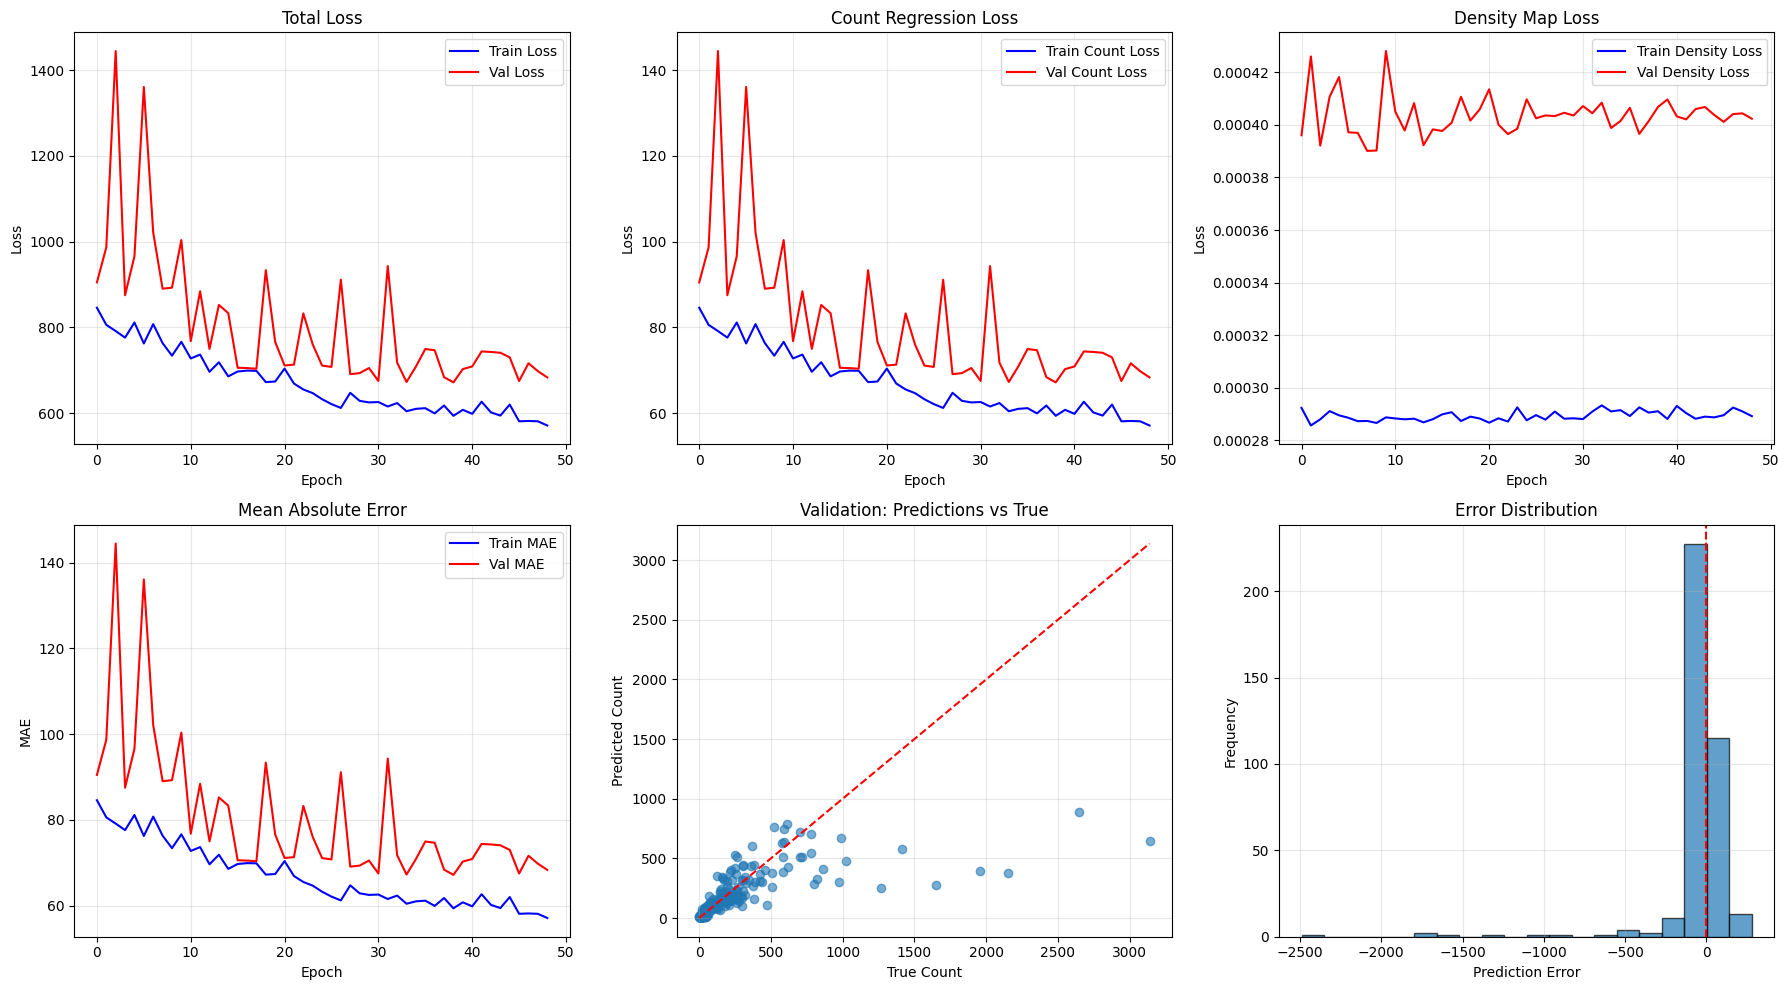

In [13]:
def evaluate_hybrid_model(
    model: nn.Module,
    data_loader: DataLoader,
    dataset_name="Dataset"
):
    """Comprehensive evaluation of hybrid model."""
    model.eval()

    all_pred_counts = []
    all_true_counts = []
    all_pred_densities = []
    all_true_densities = []

    with torch.no_grad():
        for images, density_maps, counts in data_loader:
            images = images.to(device)
            density_maps = density_maps.to(device)
            counts = counts.to(device)

            pred_density, pred_count = model(images)

            all_pred_counts.extend(pred_count.cpu().numpy())
            all_true_counts.extend(counts.cpu().numpy())
            all_pred_densities.extend(pred_density.cpu().numpy())
            all_true_densities.extend(density_maps.cpu().numpy())

    pred_counts = np.array(all_pred_counts)
    true_counts = np.array(all_true_counts)

    # Calculate metrics
    mae = mean_absolute_error(true_counts, pred_counts)
    mse = mean_squared_error(true_counts, pred_counts)
    rmse = np.sqrt(mse)

    # Additional metrics
    mape = np.mean(np.abs((true_counts - pred_counts) / (true_counts + 1e-8))) * 100
    correlation = np.corrcoef(true_counts, pred_counts)[0, 1]

    print(f"\n{dataset_name} Evaluation Results:")
    print("-" * 40)
    print(f"MAE (Count):     {mae:.4f}")
    print(f"MSE (Count):     {mse:.4f}")
    print(f"RMSE (Count):    {rmse:.4f}")
    print(f"MAPE (%):        {mape:.2f}")
    print(f"Correlation:     {correlation:.4f}")
    print(f"Mean True Count: {np.mean(true_counts):.2f}")
    print(f"Mean Pred Count: {np.mean(pred_counts):.2f}")

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'correlation': correlation,
        'pred_counts': pred_counts,
        'true_counts': true_counts
    }

# Evaluate on both sets
train_results = evaluate_hybrid_model(model, train_loader, "Training Set")
val_results = evaluate_hybrid_model(model, val_loader, "Validation Set")

# Plot training history
def plot_hybrid_training_history(history):
    """Plot training history for hybrid model."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Total loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Count loss
    axes[0, 1].plot(history['train_count_loss'], label='Train Count Loss', color='blue')
    axes[0, 1].plot(history['val_count_loss'], label='Val Count Loss', color='red')
    axes[0, 1].set_title('Count Regression Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Density loss
    axes[0, 2].plot(history['train_density_loss'], label='Train Density Loss', color='blue')
    axes[0, 2].plot(history['val_density_loss'], label='Val Density Loss', color='red')
    axes[0, 2].set_title('Density Map Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # MAE
    axes[1, 0].plot(history['train_mae'], label='Train MAE', color='blue')
    axes[1, 0].plot(history['val_mae'], label='Val MAE', color='red')
    axes[1, 0].set_title('Mean Absolute Error')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Predictions vs targets
    axes[1, 1].scatter(val_results['true_counts'], val_results['pred_counts'], alpha=0.6)
    axes[1, 1].plot([0, max(val_results['true_counts'])], [0, max(val_results['true_counts'])], 'r--')
    axes[1, 1].set_xlabel('True Count')
    axes[1, 1].set_ylabel('Predicted Count')
    axes[1, 1].set_title('Validation: Predictions vs True')
    axes[1, 1].grid(True, alpha=0.3)

    # Error distribution
    errors = val_results['pred_counts'] - val_results['true_counts']
    axes[1, 2].hist(errors, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 2].axvline(x=0, color='red', linestyle='--')
    axes[1, 2].set_xlabel('Prediction Error')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Error Distribution')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_hybrid_training_history(training_history)

# 6. Visualization of Predictions

IndexError: tuple index out of range

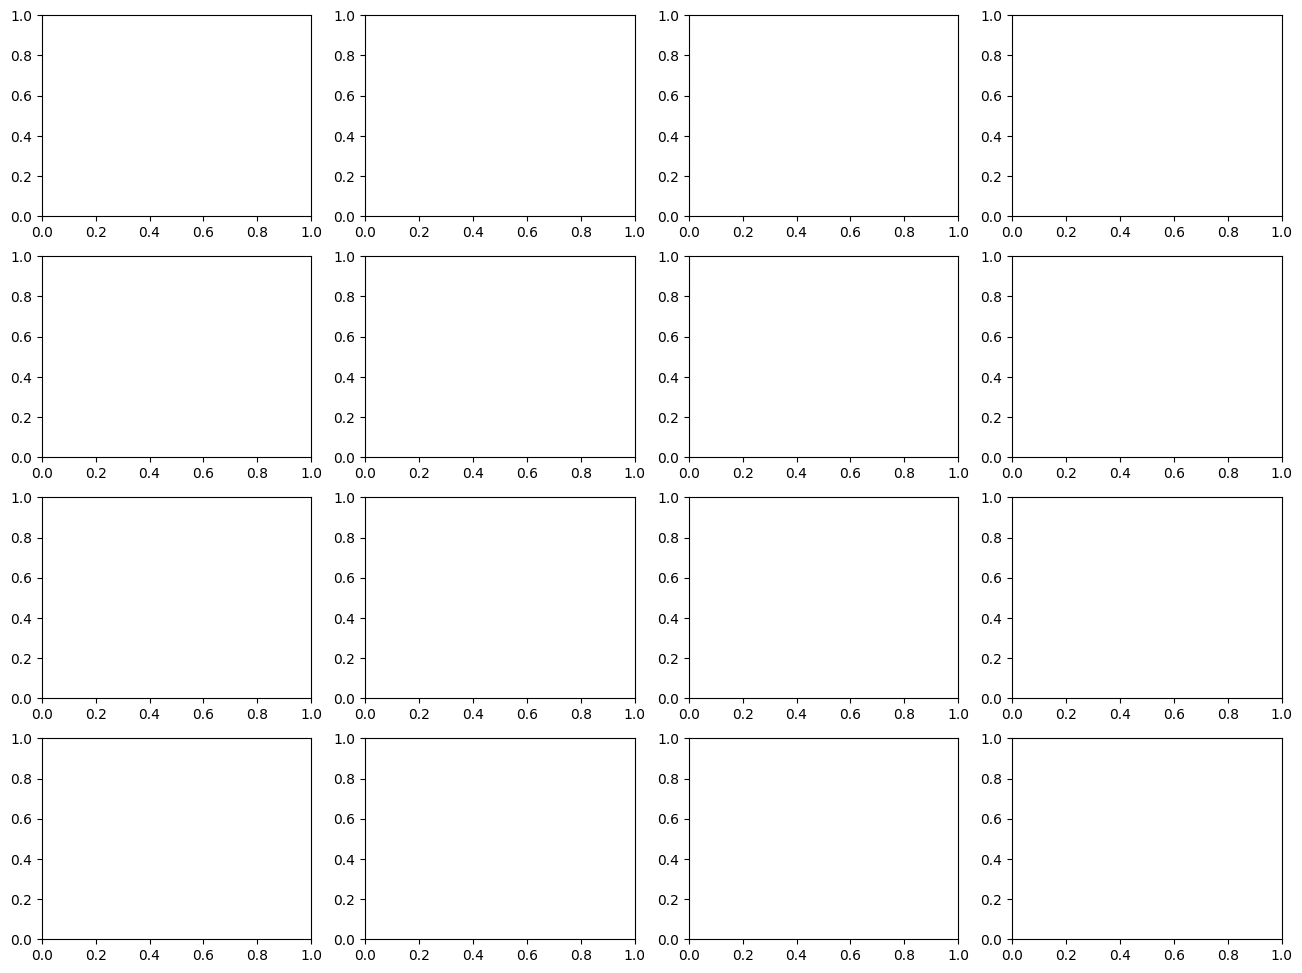

In [15]:
def visualize_hybrid_predictions(
    model,
    dataset,
    num_samples=8
):
    """Visualize density maps and count predictions."""
    model.eval()

    # Get sample data
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples // 2, 4, figsize=(16, 12))
    axes = axes.flatten()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Ensure we don't exceed the number of subplots
            if i >= num_samples // 2:
                break

            image, true_density, true_count = dataset[idx]
            image_batch = image.unsqueeze(0).to(device)

            # Get predicted density and count
            # Pass true_density_size to match the output size during visualization
            pred_density, pred_count = model(image_batch, true_density_size=(true_density.shape[2], true_density.shape[3]))


            # Denormalize image for visualization
            img_viz = image.clone()
            img_viz = img_viz * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img_viz = torch.clamp(img_viz, 0, 1).permute(1, 2, 0).numpy()

            # Original image
            axes[i*4].imshow(img_viz)
            axes[i*4].set_title(f'Original\nTrue: {true_count:.0f}, Pred: {pred_count.item():.1f}')
            axes[i*4].axis('off')

            # True density map (squeeze channel dim)
            true_density_viz = true_density.squeeze().cpu().numpy()
            axes[i*4 + 1].imshow(true_density_viz, cmap='hot')
            axes[i*4 + 1].set_title('True Density')
            axes[i*4 + 1].axis('off')

            # Predicted density map (squeeze channel dim)
            pred_density_viz = pred_density.squeeze().cpu().numpy()
            axes[i*4 + 2].imshow(pred_density_viz, cmap='hot')
            axes[i*4 + 2].set_title('Predicted Density')
            axes[i*4 + 2].axis('off')

            # Density difference
            # Now they should have the same size for subtraction
            diff = pred_density_viz - true_density_viz
            im = axes[i*4 + 3].imshow(diff, cmap='RdBu', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
            axes[i*4 + 3].set_title('Difference')
            axes[i*4 + 3].axis('off')
            # Add colorbar only once or manage placement carefully
            if i == 0: # Add colorbar for the first sample in the row
                fig.colorbar(im, ax=axes[i*4 + 3])


    plt.suptitle('Hybrid Model Predictions: Density Maps + Counts', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_hybrid_predictions(model, val_dataset, num_samples=8) # Increased num_samples to fill the subplots

# 7. Test Set Prediction and Submissions

In [16]:
from pandas.core.frame import DataFrame


class TestDataset(Dataset):
    """Dataset for test images."""
    def __init__(self, image_dir: str, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')],
                                 key=lambda x: int(os.path.splitext(x)[0]))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, img_name

def generate_hybrid_test_predictions(
    model,
    test_dir,
    output_file='hybrid_submission.csv'
) -> DataFrame:
    """Generate test predictions using the hybrid model."""
    print("Generating test predictions with hybrid model...")

    test_dataset = TestDataset(test_dir, test_transforms)
    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2
    )

    model.eval()
    predictions = []
    image_names = []

    with torch.no_grad():
        for images, names in test_loader:
            images = images.to(device)
            pred_density, pred_count = model(images)

            # Use count predictions for submission
            batch_preds = pred_count.cpu().numpy()
            predictions.extend([max(0, int(round(pred))) for pred in batch_preds])
            image_names.extend(names)

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'image_id': image_names,
        'predicted_count': predictions
    })

    # Sort by image_id
    submission_df['sort_key'] = submission_df['image_id'].apply(lambda x: int(os.path.splitext(x)[0]))
    submission_df = submission_df.sort_values('sort_key').drop('sort_key', axis=1).reset_index(drop=True)

    # Save submission
    submission_df.to_csv(output_file, index=False)

    print(f"Submission saved to {output_file}")
    print(f"Predictions for {len(submission_df)} test images")

    # Statistics
    pred_counts = submission_df['predicted_count'].values
    print(f"\nTest Predictions Statistics:")
    print(f"Min: {pred_counts.min()}")
    print(f"Max: {pred_counts.max()}")
    print(f"Mean: {pred_counts.mean():.2f}")
    print(f"Median: {np.median(pred_counts):.2f}")

    return submission_df

# Generate test predictions
submission_df = generate_hybrid_test_predictions(model, TEST_IMG_DIR)

# Display first few rows
print("\nFirst 10 rows of submission:")
print(submission_df.head(10))

Generating test predictions with hybrid model...
Submission saved to hybrid_submission.csv
Predictions for 500 test images

Test Predictions Statistics:
Min: 5
Max: 1105
Mean: 114.51
Median: 25.50

First 10 rows of submission:
  image_id  predicted_count
0    1.jpg                7
1    2.jpg               34
2    3.jpg              222
3    4.jpg              706
4    5.jpg              140
5    6.jpg              420
6    7.jpg              119
7    8.jpg              825
8    9.jpg                6
9   10.jpg               89


# 8. Final Summary and Results

In [17]:
print("="*60)
print("HYBRID CROWD COUNTING MODEL - FINAL SUMMARY")
print("="*60)

print(f"\nModel Architecture: SimpleCountingNet")
print(f"- CNN Backbone: Custom 4-layer CNN")
print(f"- Dual outputs: Density maps + Direct count regression")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nTraining Configuration:")
print(f"- Training images: {len(train_dataset)}")
print(f"- Validation images: {len(val_dataset)}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Loss function: Hybrid (Density MSE + Count L1)")

print(f"\nFinal Performance Metrics:")
print(f"- Training MAE: {train_results['mae']:.4f}")
print(f"- Validation MAE: {val_results['mae']:.4f}")
print(f"- Validation RMSE: {val_results['rmse']:.4f}")
print(f"- Validation Correlation: {val_results['correlation']:.4f}")

print(f"\nKey Advantages of Hybrid Approach:")
print(f"- Combines spatial density information with global count regression")
print(f"- Density maps provide spatial understanding")
print(f"- Count regression ensures accurate total predictions")
print(f"- Mutual supervision improves both predictions")

print(f"\nTest Set Predictions:")
print(f"- Generated predictions for {len(submission_df)} test images")
print(f"- Mean predicted count: {submission_df['predicted_count'].mean():.2f}")
print(f"- Prediction range: {submission_df['predicted_count'].min()} to {submission_df['predicted_count'].max()}")

print(f"\nNext Steps for Improvement:")
print(f"- Implement proper point annotations for better density maps")
print(f"- Add attention mechanisms to focus on crowd regions")
print(f"- Experiment with different loss function weights")
print(f"- Use pretrained backbones (ResNet, EfficientNet)")
print(f"- Implement multi-scale training and testing")

print("="*60)

HYBRID CROWD COUNTING MODEL - FINAL SUMMARY

Model Architecture: SimpleCountingNet
- CNN Backbone: Custom 4-layer CNN
- Dual outputs: Density maps + Direct count regression
- Total parameters: 3,157,634

Training Configuration:
- Training images: 1520
- Validation images: 380
- Batch size: 8
- Loss function: Hybrid (Density MSE + Count L1)

Final Performance Metrics:
- Training MAE: 56.0915
- Validation MAE: 67.7430
- Validation RMSE: 238.5340
- Validation Correlation: 0.7256

Key Advantages of Hybrid Approach:
- Combines spatial density information with global count regression
- Density maps provide spatial understanding
- Count regression ensures accurate total predictions
- Mutual supervision improves both predictions

Test Set Predictions:
- Generated predictions for 500 test images
- Mean predicted count: 114.51
- Prediction range: 5 to 1105

Next Steps for Improvement:
- Implement proper point annotations for better density maps
- Add attention mechanisms to focus on crowd region